<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Analyzing_data_in_the_JARVIS_Leaderboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing data in [JARVIS-Leaderbaord](https://pages.nist.gov/jarvis_leaderboard/)

# Table of contents

1. Install/download JARVIS-Leaderboard
2. Example of getting data for a particular benchmark
3. List of all available benchmarks
4. Example MAEs for AI formation energy and ES silicon bandgap benchmarks as bar plots
5. Example results for AI, ES, QC and EXP results as scatter plots
6. Distribution of data in each dataset
7. MAD and MAE ratio
8. Generate bar plot figures for all benchmarks


In [1]:
import os
if not os.path.exists('jarvis_leaderboard'):
  !git clone https://github.com/usnistgov/jarvis_leaderboard.git
os.chdir('jarvis_leaderboard')
!pip install -e .

Cloning into 'jarvis_leaderboard'...
remote: Enumerating objects: 41004, done.
remote: Counting objects: 100% (9804/9804), done.
remote: Compressing objects: 100% (1102/1102), done.
remote: Total 41004 (delta 5176), reused 9541 (delta 5072), pack-reused 31200
Receiving objects: 100% (41004/41004), 285.18 MiB | 29.41 MiB/s, done.
Resolving deltas: 100% (21344/21344), done.
Updating files: 100% (2465/2465), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/jarvis_leaderboard
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Example of getting data for a particular benchmark

In [2]:
from jarvis_leaderboard.rebuild import get_metric_value,get_results

In [3]:
names,vals=get_results(bench_name='AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip')

In [4]:
names

array(['kgcnn_coGN', 'potnet', 'matformer_256', 'alignn_model',
       'kgcnn_schnet', 'cgcnn_model', 'matminer_xgboost', 'matminer_rf',
       'matminer_lgbm', 'kgcnn_cgcnn', 'cfid', 'cfid_chem'], dtype='<U16')

In [5]:
vals

array([0.0271, 0.0293, 0.0322, 0.0331, 0.061 , 0.0625, 0.0734, 0.096 ,
       0.1023, 0.1194, 0.1419, 0.2226])

List of available benchmarks

In [6]:
import glob
benchmarks = []
for i in glob.glob("jarvis_leaderboard/contributions/*/*csv.zip"):
  name = i.split("/")[-1]
  if name not in benchmarks:
    benchmarks.append(name)

print('Example 10 files', benchmarks[0:10])
print('Total', len(benchmarks))


Example 10 files ['AI-MLFF-energy-mlearn_Ni-test-mae.csv.zip', 'AI-MLFF-forces-mlearn_Ni-test-multimae.csv.zip', 'QC-EigenSolver-electron_bands_JVASP_816_Al_WTBH-dft_3d-test-multimae.csv.zip', 'FF-SinglePropertyPrediction-bulk_modulus_JVASP_867_Cu-dft_3d-test-mae.csv.zip', 'FF-SinglePropertyPrediction-bulk_modulus_JVASP_816_Al-dft_3d-test-mae.csv.zip', 'EXP-Spectra-co2_RM_8852-nist_isodb-test-multimae.csv.zip', 'AI-TextClass-categories-pubchem-test-acc.csv.zip', 'AI-TextClass-categories-arXiv-test-acc.csv.zip', 'AI-ImageClass-bravais_class-stem_2d_image-test-acc.csv.zip', 'FF-SinglePropertyPrediction-bulk_modulus_JVASP_1002_Si-dft_3d-test-mae.csv.zip']
Total 274


Example mean absolute errors for AI formation
energy and ES silicon bandgap benchmarks

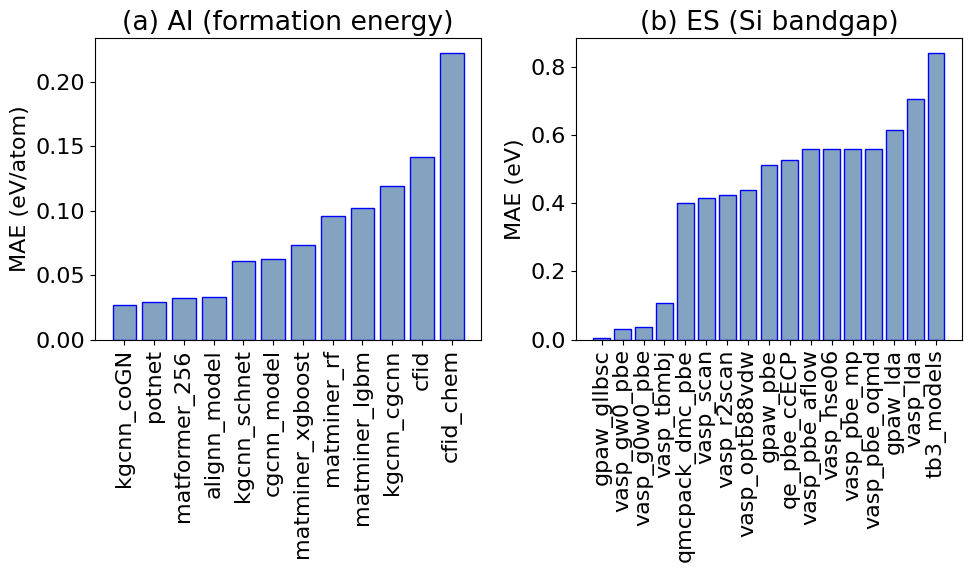

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from jarvis_leaderboard.rebuild import get_metric_value,get_results
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.values())
colors=np.repeat([0.1, 0.1, 0.1, 0.1],10)

the_grid = GridSpec(1, 2)
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,6))

plt.subplot(the_grid[0, 0])
names,vals=get_results(bench_name='AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip')
plt.bar(np.arange(len(vals)),vals,color=(0.2, 0.4, 0.6, 0.6),edgecolor='blue')
plt.xticks(np.arange(len(vals)),names,rotation=90)
plt.ylabel('MAE (eV/atom)')
plt.title('(a) AI (formation energy)')

plt.subplot(the_grid[0, 1])
names,vals=get_results(bench_name='ES-SinglePropertyPrediction-bandgap_JVASP_1002_Si-dft_3d-test-mae.csv.zip')
#plt.bar(np.arange(len(vals)),vals,color=colors[:len(vals)], edgecolor='blue')
plt.bar(np.arange(len(vals)),vals,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
plt.xticks(np.arange(len(vals)),names,rotation=90)
plt.ylabel('MAE (eV)')
plt.title('(b) ES (Si bandgap)')

plt.tight_layout()
plt.show()

In [8]:
!pwd

/content/jarvis_leaderboard


Example results for AI, ES, QC and EXP results. a) formation-energy-peratom model using AI, b) bulk modulus predictions using ES methods, c) electronic bandstructure of Al using QV methods with different quantum circuits, d) CO2 capture for zeolite at several labs in round-robin fashion.

In [9]:
import glob
ai_form_en={}
es_kv={}
qc_eig={}
exp_co2={}
for i in glob.glob("jarvis_leaderboard/contributions/*/*.csv.zip"):

    bench_name = i.split("/")[-2]
    if i.split('/')[-1]=='AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip':
        res = get_metric_value(csv_path=i)
        ai_form_en[bench_name]=res['df']

    if i.split('/')[-1]=='ES-SinglePropertyPrediction-bulk_modulus-dft_3d-test-mae.csv.zip':
    #if i.split('/')[-1]=='ES-SinglePropertyPrediction-bandgap-dft_3d-test-mae.csv.zip':
        res = get_metric_value(csv_path=i)
        es_kv[bench_name]=res['df']
    if i.split('/')[-1]=='QC-EigenSolver-electron_bands_JVASP_816_Al_WTBH-dft_3d-test-multimae.csv.zip':
        res = get_metric_value(csv_path=i)
        qc_eig[bench_name]=res['df']
    if i.split('/')[-1]=='EXP-Spectra-co2_RM_8852-nist_isodb-test-multimae.csv.zip':
        res = get_metric_value(csv_path=i)
        exp_co2[bench_name]=res['df']

0 C6 #1f77b4
1 C5 #ff7f0e
2 C3 #2ca02c
3 C1 #d62728
4 C4 #9467bd
5 C2 #8c564b


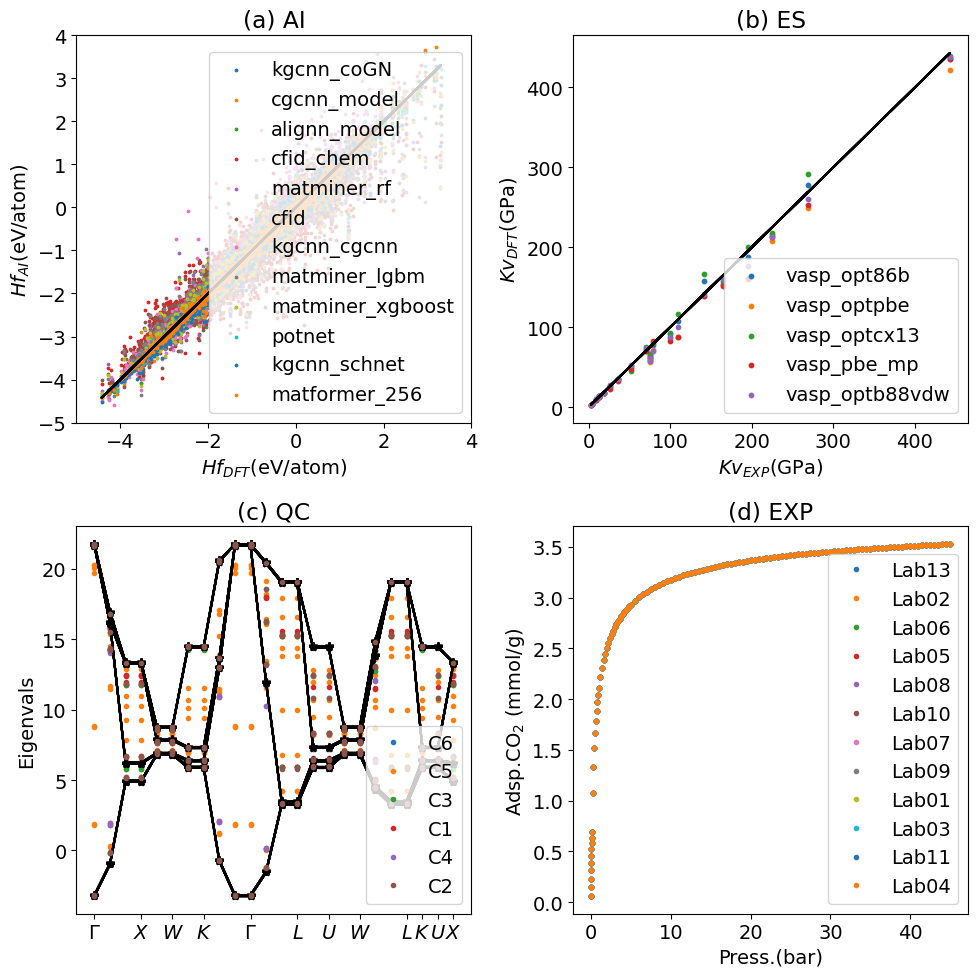

In [10]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(2, 2)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,10))

plt.subplot(the_grid[0, 0])
plt.xlabel('$Hf_{DFT}$(eV/atom)')
plt.ylabel('$Hf_{AI}$(eV/atom)')
plt.title('(a) AI')
for i,j in ai_form_en.items():
    plt.scatter(j['actual'],j['prediction'],s=3,label=i)
    plt.plot(j['actual'],j['actual'],c='black')
plt.legend()
plt.xlim([-5,4])
plt.ylim([-5,4])

plt.subplot(the_grid[0, 1])
plt.title('(b) ES')
plt.ylabel('$Kv_{DFT}$(GPa)')
plt.xlabel('$Kv_{EXP}$(GPa)')
for i,j in es_kv.items():
    plt.scatter(j['actual'],j['prediction'],s=10,label=i)
    plt.plot(j['actual'],j['actual'],c='black')
plt.legend()



plt.subplot(the_grid[1, 0])

count=0
colors = list(mcolors.TABLEAU_COLORS.values())
for i,j in qc_eig.items():
    actual=np.array(j['actual'].values[0].split(';'),dtype='float').reshape(24,8)
    pred=np.array(j['prediction'].values[0].split(';'),dtype='float').reshape(24,8)

    for ii,jj in enumerate(actual.T):
#         if ii==0:
#             plt.plot(jj,'-*',c='g',label='NP')
        plt.plot(jj,'-*',c='black')

    for ii,jj in enumerate(pred.T):
#         if ii==0:
#             plt.plot(jj,'*',c='b',label=i.split('qiskit_vqd_SU2_')[1])
        if ii==0:
            lbl = i.split('qiskit_vqd_SU2_')[1].replace('c','C')


            plt.plot(jj,'.',label=lbl,c=colors[count])
            print(count,lbl,colors[count])

        else:
            plt.plot(jj,'.',c=colors[count])
    count+=1

kp=[0, 3, 5, 7, 10, 13, 15, 17, 20, 21, 22, 23]
lbls=['$\\Gamma$', '$X$', '$W$', '$K$', '$\\Gamma$', '$L$', '$U$', '$W$', '$L$', '$K$', '$U$', '$X$']
plt.xticks(kp,lbls)
plt.legend(loc='lower right')
plt.title('(c) QC')
plt.ylabel('Eigenvals')



plt.subplot(the_grid[1, 1])

press=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.4, 4.6, 4.8, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5, 26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 30, 30.5, 31, 31.5, 32, 32.5, 33, 33.5, 34, 34.5, 35, 35.5, 36, 36.5, 37, 37.5, 38, 38.5, 39, 39.5, 40, 40.5, 41, 41.5, 42, 42.5, 43, 43.5, 44, 44.5, 45]

for i,j in exp_co2.items():
    actual=np.array(j['actual'].values[0].split(';'),dtype='float')
    pred=np.array(j['prediction'].values[0].split(';'),dtype='float')
    #press=np.log(press)
#     pred=np.exp(pred)
#     actual=np.exp(actual)
    plt.plot(press,actual,'.',label=i.split('x.')[-1])
plt.legend()
plt.title('(d) EXP')
plt.xlabel('Press.(bar)')
plt.ylabel('Adsp.CO$_2$ (mmol/g)')


plt.tight_layout()
plt.show()
# plt.savefig('results_example.pdf')
# plt.close()

Distribution of data in each dataset. a) all entries in leaderboard, b) entries with unique identifiers. Note one identifier can have multiple properties.

In [11]:
import glob
import zipfile
import numpy as np
import json,os
from jarvis.db.jsonutils import loadjson
from collections import defaultdict
import pandas as pd
from sklearn.metrics import mean_absolute_error, accuracy_score


id_info = defaultdict()
for csv_path in glob.glob("jarvis_leaderboard/contributions/*/*.csv.zip"):

    fname = csv_path.split("/")[-1].split(".csv.zip")[0]
    contribution = csv_path.split("/")[-2]
    temp = fname.split("-")
    category = temp[0]
    subcat = temp[1]
    prop = temp[2]
    dataset = temp[3]
    data_split = temp[4]
    metric = temp[-1]



    data_split='test'
    json_name = dataset + "_" + prop + ".json"
    json_path = 'jarvis_leaderboard/benchmarks/'+category+'/'+subcat+'/'+json_name+'.zip'
    z = zipfile.ZipFile(json_path)
    json_data = json.loads(z.read(json_name))
    if dataset not in id_info:
        id_info[dataset]=[]


    if "val" in json_data:  # sometimes just train-test
        data_size = (
            len(json_data["train"])
            + len(json_data["val"])
            + len(json_data["test"])
        )
        for m in list(json_data["train"].keys()):

                id_info[dataset].append(m)
        for m in list(json_data["val"].keys()):

                id_info[dataset].append(m)
        for m in list(json_data["test"].keys()):

                id_info[dataset].append(m)
    else:
        data_size = len(json_data["train"]) + len(json_data["test"])
        for m in list(json_data["train"].keys()):

                id_info[dataset].append(m)

        for m in list(json_data["test"].keys()):

                id_info[dataset].append(m)

mlearn_Ni 2940 294
dft_3d 6936000 55713
nist_isodb 12 1
pubchem 400500 44500
arXiv 908946 87148
stem_2d_image 18300 9150
mlearn_Si 1912 239
mlearn_Cu 2344 293
mlearn_Li 2160 270
mlearn_Ge 2024 253
mlearn_Mo 1736 217
alignn_ff_db 2149777 307111
vacancydb_oxides_train_test 30 30
midas 5 1
ssub 18986 1726
supercon_chem 180554 16414
mag2d_chem 2486 226
qe_tb 9954888 829574
lj_2d_liquid 2 1
vacancydb_elements 74 74
vacancydb_oxides 65 65
vacancydb_2D 72 72
vacancydb 569 530
ocp100k 449658 149886
hmof 2890671 137651
qmof 61272 20424
snumat 31158 10386
qm9_std_jctc 1569948 130829
ocp_all 1020428 510214
ocp10k 179658 59886
megnet 415434 69239
halide_peroskites 1145 229
tinnet_N 327 327
edos_pdos 14243 14243
arxiv_gen 1470 490
biobench 9 3
dft_2d 2 2
mxene275 274 274
arxiv_summary 87148 87148
mat_scholar_ner 123267 123267


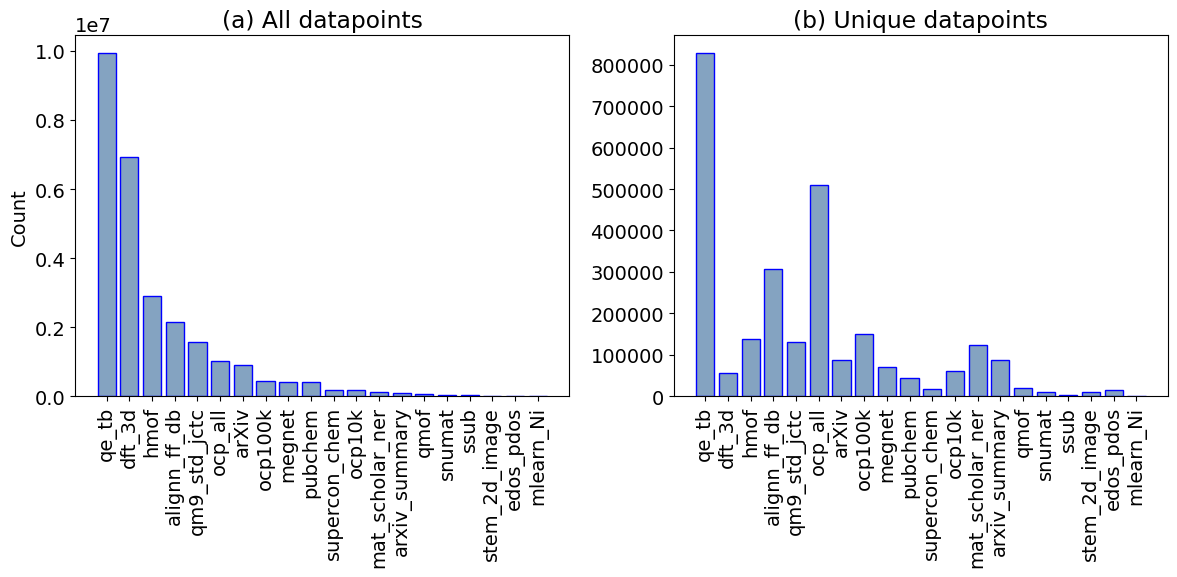

In [12]:
import numpy as np
names=[]
all_ids=[]
unique_ids=[]
for i,j in id_info.items():
    print (i,len(j),len(set(j)))
    names.append(i)
    all_ids.append(len(j))
    unique_ids.append(len(set(j)))


take=20
order = np.argsort(all_ids)[::-1]
names=np.array(names)[order][0:take]
all_ids=np.array(all_ids)[order][0:take]
unique_ids=np.array(unique_ids)[order][0:take]
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(1, 2)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12,6))

plt.subplot(the_grid[0, 0])
plt.title('(a) All datapoints')
plt.ylabel('Count')

#plt.bar(names,all_ids,facecolor = '#2ab0ff', edgecolor='b',alpha=0.7)
plt.bar(names,all_ids,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
plt.xticks(rotation=90)
plt.subplot(the_grid[0, 1])
plt.title('(b) Unique datapoints')
#plt.bar(names,unique_ids,facecolor = '#2ab0ff', edgecolor='b',alpha=0.7)
plt.bar(names,unique_ids,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
# plt.savefig('data_dist.pdf')
# plt.close()

Mean absolute deviation to mean absolute ratio, MAD and MAE for a) AI and b) electronic structure methods. MAD:MAE serves as uniform criteria for comparing performances of models.

54

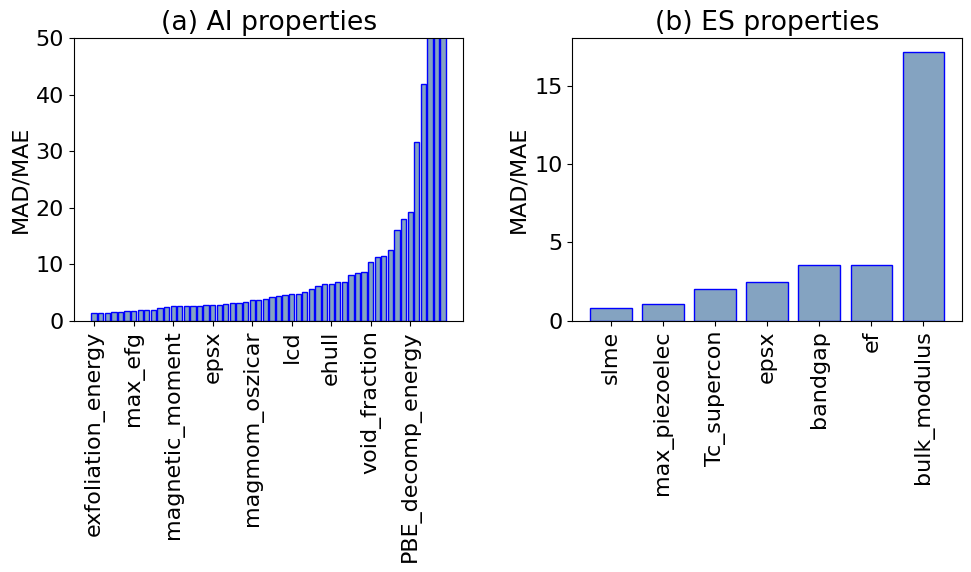

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

the_grid = GridSpec(1, 2)
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,6))

plt.subplot(the_grid[0, 0])
plt.title('(a) AI properties')
plt.ylabel('MAD/MAE')

mad_maes=[]
mad_maes_names=[]
ai_single_prop = []
for i in glob.glob("jarvis_leaderboard/contributions/*/AI-SinglePropertyPrediction*.csv.zip"):
    nm=i.split('/')[-1].split('-')[2].replace('optb88vdw','OPT')
    if 'qm9' not in i and nm not in mad_maes_names: #requires scaling factor
        tmp= i.split('/')[-1]
        res=get_metric_value(i)
        random_guessing_performance=res['random_guessing_performance']
        mae=res['res']
        mad_mae = random_guessing_performance/mae
        mad_maes.append(mad_mae)
        mad_maes_names.append(nm)
        #break
        if tmp not in ai_single_prop:
            ai_single_prop.append(tmp)
mad_maes=np.array(mad_maes)
mad_maes_names=np.array(mad_maes_names)
order=np.argsort(mad_maes)
mad_maes=mad_maes[order]
mad_maes_names=mad_maes_names[order]

back=mad_maes_names
plt.subplot(the_grid[0, 0])
plt.bar(np.arange(len(mad_maes)),mad_maes,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
plt.ylim([0,50])
plt.xticks(np.arange(len(mad_maes)),mad_maes_names,rotation=90)
plt.locator_params(axis='x', nbins=10)




plt.subplot(the_grid[0, 1])
plt.title('(b) ES properties')
plt.ylabel('MAD/MAE')
mad_maes=[]
mad_maes_names=[]
es_single_prop = []
for i in glob.glob("jarvis_leaderboard/contributions/*/ES-SinglePropertyPrediction*.csv.zip"):
    nm=i.split('/')[-1].split('-')[2]
    if 'JVASP' not in i and nm not in mad_maes_names: #single data
        tmp= i.split('/')[-1]
        res=get_metric_value(i)
        random_guessing_performance=res['random_guessing_performance']
        mae=res['res']
        mad_mae = random_guessing_performance/mae
        mad_maes.append(mad_mae)
        mad_maes_names.append(nm)
        #break
        if tmp not in es_single_prop:
            es_single_prop.append(tmp)
mad_maes=np.array(mad_maes)
mad_maes_names=np.array(mad_maes_names)
order=np.argsort(mad_maes)
mad_maes=mad_maes[order]
mad_maes_names=mad_maes_names[order]

len(es_single_prop)




plt.bar(np.arange(len(mad_maes)),mad_maes,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
plt.xticks(np.arange(len(mad_maes)),mad_maes_names,rotation=90)
plt.locator_params(axis='x', nbins=8)

#plt.ylim([0,100])
plt.tight_layout()
len(ai_single_prop)

Generate figures for all benchmarks

In [14]:
%%time
#Supplementary information plot with more than 274 figures!
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 7})

count = 0
with PdfPages('jarvis_leaderboard_benchmarks.pdf') as pdf:
    plt.figure(figsize=(6, 6))
    for i in benchmarks:
      names,vals=get_results(bench_name=i)
      plt.bar(np.arange(len(vals)),vals,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
      plt.xticks(np.arange(len(vals)),names,rotation=90)
      title = 'Fig S'+str(count+1)+':'+i
      count+=1
      plt.title(title)
      metric = (i.split('.csv.zip')[0].split('-')[-1]).upper()
      plt.ylabel(metric)
      plt.tight_layout()
      pdf.savefig()  # saves the current figure into a pdf page
      plt.close()




    d = pdf.infodict()
    d['Title'] = 'Multipage PDF Example'
    d['Author'] = 'NIST-JARVIS'
    d['Subject'] = 'How to create a multipage pdf file and set its metadata for JARVIS-Leaderboard'
    d['Keywords'] = 'PdfPages multipage keywords author title subject'
    d['CreationDate'] = datetime.datetime(2009, 11, 13)
    d['ModDate'] = datetime.datetime.today()
#To see/download the generated pdf, navigate to 'Files'>'jarvis_leaderboard' folder (on the left side of the notebook with folder icon)


CPU times: user 1min 30s, sys: 28.3 s, total: 1min 59s
Wall time: 1min 32s
